___
___

# Predicción del tráfico en celdas de comunicaciones móviles:

___
___

Una **red celular o red móvil** es una red de comunicación en la que el último enlace es inalámbrico. La red se distribuye en zonas terrestres llamadas "células", cada una de ellas servida por al menos un transceptor (transmisor y receptor) de localización fija, pero más normalmente, tres emplazamientos o estaciones base. 

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Frequency_reuse.svg/600px-Frequency_reuse.svg.png' width=300px></img>

Estas estaciones base proporcionan a la célula la cobertura de red que puede utilizarse para la transmisión de voz, datos y otros tipos de contenido. 

Una célula suele utilizar un **conjunto de frecuencias diferente** al de las células vecinas, para evitar interferencias y proporcionar una calidad de servicio garantizada dentro de cada célula.

Dependiendo del tráfico a soportar, las células son más o menos grandes y se necesitan más o menos estaciones base.

<img src='https://www.tnuda.org.il/files/d1db9a328f8de69ddbc9d819763c27b5/resht%201%20%283%29%20communication%20coverage%20by%20spatial%20division%20to%20cells%20with%20base%20stations_2.jpg' width=300px></img>

## Dataset:


El conjunto de datos de actividad del teléfono móvil está compuesto por **una semana de registros de detalles de llamadas (CDR)** de la ciudad de Milán y la provincia de Trentino (Italia).

Cada vez que un usuario participa en una interacción de telecomunicaciones, el operador le asigna una estación base de radio (RBS) y entrega la comunicación a través de la red. Luego, se crea un nuevo CDR que registra el tiempo de la interacción y la RBS que la gestionó. Las siguientes actividades están presentes en el conjunto de datos:

SMS recibido
SMS enviado
llamadas entrantes
llamadas salientes
Actividad en internet

En particular, la actividad en Internet se genera cada vez que un usuario inicia o termina una conexión a Internet. Además, durante la misma conexión se genera un CDR si la conexión dura más de 15 minutos o el usuario transfiere más de 5 MB.

Los conjuntos de datos se agregan espacialmente en una cuadrícula de celdas cuadradas. El área de Milán está compuesta por una cuadrícula superpuesta de 1.000 cuadrados con un tamaño de unos 235×235 metros. Esta cuadrícula se proyecta con el estándar WGS84 (EPSG:4326).

Los datos los puedes descargar del campus.

## Importación de librerías:

In [1]:
!pip install geojson

In [2]:
!pip install descartes

In [3]:
# Librerías para tratamiento de datos
import pandas as pd
import numpy as np
import os

# Librerías para visualización de datos
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns
import geojson
from descartes import PolygonPatch

# Librerías para la realización de modelos
import scipy
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [4]:
for file in os.listdir('data'):
    print(file)

350_793533_bundle_archive.zip
ISTAT_census_variables_2011.csv
Italian_provinces.geojson
mi-to-provinces-2013-11-01.csv
mi-to-provinces-2013-11-02.csv
mi-to-provinces-2013-11-03.csv
mi-to-provinces-2013-11-04.csv
mi-to-provinces-2013-11-05.csv
mi-to-provinces-2013-11-06.csv
mi-to-provinces-2013-11-07.csv
milano-grid.geojson
sms-call-internet-mi-2013-11-01.csv
sms-call-internet-mi-2013-11-02.csv
sms-call-internet-mi-2013-11-03.csv
sms-call-internet-mi-2013-11-04.csv
sms-call-internet-mi-2013-11-05.csv
sms-call-internet-mi-2013-11-06.csv
sms-call-internet-mi-2013-11-07.csv


## Definición de funciones: 

In [5]:
def func(xdata, a,b,c):
    '''
    Función que modeliza datos con un seno de periodo 24 
    '''
    return a*np.sin(2*np.pi*(1/24)*xdata+b)+c

def devuelve_cdrs():
    '''
    Función de preprocesamiento para unir todos los datos de CDRs y preprocesarlos
    '''
    df = pd.DataFrame({})
    for i in range(1,8):
        df_raw = pd.read_csv('./data/sms-call-internet-mi-2013-11-0{}.csv'.format(i), parse_dates=['datetime'])
        df = df.append(df_raw)
    df=df.fillna(0)
    df['sms'] = df['smsin'] + df['smsout']
    df['calls'] = df['callin'] + df['callout']
    df = df[['datetime', 'CellID', 'internet', 
             'calls', 'callin', 'callout',
             'sms', 'smsin', 'smsout']].groupby(['datetime', 'CellID'], as_index=False).sum()
    df['hour'] = df.datetime.dt.hour+24*(df.datetime.dt.day-1)
    df = df.set_index(['hour']).sort_index()    
    return df

def representa_actividad_celda(df, lista_celdas, lista_labels, representar='internet', tamanio_figura=[12,7]):
    '''
    Función para representar todas las celdas geográficamente y su nivel de tráfico
    '''
    figura = plt.figure(figsize=tamanio_figura)
    ax = df[df.CellID==lista_celdas[0]][representar].plot(label=lista_labels[0])
    if len(lista_celdas)>1:
        for celda, label in zip(lista_celdas[1:], lista_labels[1:]):
            df[df.CellID==celda][representar].plot(ax=ax, label=label)        
    plt.title(u'Representación de {0} horario en la/s celda/s'.format(representar))
    plt.xlabel("Hora semanal")
    plt.ylabel("Cantidad de conexiones/sms/llamadas")
    sns.despine()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5)
    
def devuelve_celda_punto(json_poligonos, punto):
    '''
    Función que recibe un json con polígonos (en este caso las celdas) y un punto (latitud y longitud). 
    Imprime por pantalla qué celda contiene el punto que recibe como parámetro.
    '''
    for id_celda in range(len(json_poligonos.features)):
        poligono = json_poligonos.features[id_celda]['geometry']
        if PolygonPatch(poligono).contains_point(punto,radius=0.005):
            print(u'La celda {0} contiene la localización pasada'.format(id_celda))
            print(poligono)

def representa_trafico(x, y, label, titulo, ylabel = "Internet Connections [#]", xlabel = "Time [hour]"):
    '''
    Función que representa una serie temporal
    '''
    f = plt.figure(figsize=(12,7))
    plt.plot(x, y, color='black', linewidth=1, linestyle='-', label=label)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    sns.despine()
    plt.show()
    
def representa_real_vs_pred(real, pred, labels):
    '''
    Función que representa dos series temporales superpuestas
    '''
    f = plt.figure(figsize=(12,7))
    plt.plot(real['x'], real['y'], color='black', linewidth=1, linestyle='--', label=labels['real'])
    plt.plot(pred['x'], pred['y'], color='black', linewidth=3, label=labels['modelo'])
    plt.xlabel("Hora")
    plt.ylabel("# Conexiones a internet")
    plt.legend()
    sns.despine()
    plt.show()

## Lectura de datos: 

Primero de todo realizamos la lectura de datos. Los datos que vamos a escoger son las localizaciones de las celdas de telecomunicaciones de Milan y la información de los CDRs de cada una de las celdas.

In [6]:
with open("./data/milano-grid.geojson") as json_file:
    json_data = geojson.load(json_file)

In [7]:
json_data[:4]

[{"geometry": {"coordinates": [[[9.011491, 45.358801], [9.014491, 45.358801], [9.014491, 45.356686], [9.011491, 45.356686], [9.011491, 45.358801]]], "type": "Polygon"}, "id": 0, "properties": {"cellId": 1}, "type": "Feature"},
 {"geometry": {"coordinates": [[[9.014491, 45.358801], [9.017492, 45.358801], [9.017491, 45.356685], [9.014491, 45.356686], [9.014491, 45.358801]]], "type": "Polygon"}, "id": 1, "properties": {"cellId": 2}, "type": "Feature"},
 {"geometry": {"coordinates": [[[9.017492, 45.358801], [9.020492, 45.3588], [9.020492, 45.356685], [9.017491, 45.356685], [9.017492, 45.358801]]], "type": "Polygon"}, "id": 2, "properties": {"cellId": 3}, "type": "Feature"},
 {"geometry": {"coordinates": [[[9.020492, 45.3588], [9.023493, 45.358799], [9.023492, 45.356684], [9.020492, 45.356685], [9.020492, 45.3588]]], "type": "Polygon"}, "id": 3, "properties": {"cellId": 4}, "type": "Feature"}]

In [8]:
df_cdrs = devuelve_cdrs()
df_cdrs.head()

,datetime,CellID,internet,calls,callin,callout,sms,smsin,smsout
hour,,,,,,,,,
0,2013-11-01,1,57.7990,1.0212,0.5919,0.4293,3.1890,2.0843,1.1047
0,2013-11-01,2,57.9149,1.0402,0.6020,0.4382,3.1795,2.0915,1.0880
0,2013-11-01,3,58.0382,1.0604,0.6128,0.4476,3.1693,2.0992,1.0701
0,2013-11-01,4,57.4634,0.9663,0.5627,0.4036,3.2166,2.0633,1.1533
0,2013-11-01,5,52.1714,0.8850,0.5110,0.3740,2.9147,1.8708,1.0439


# Análisis exploratorio de datos:

## Analizar una nueva zona de Milán para extraer conclusiones

Vamos a analizar la zona del estadio de San Siro cuya celda se puede obtener de la siguiente manera: 

    devuelve_celda_punto(json_data, (9.12400, 45.47889))
    

Se trata de representar la actividad de la celda mediante 3 gráficas similares a las utilizadas anteriormente (para internet, sms y calls)

In [24]:
devuelve_celda_punto(json_data, (9.12400, 45.47889))

La celda 5737 contiene la localización pasada
{"coordinates": [[[9.122768, 45.479308], [9.125775, 45.479305], [9.12577, 45.477189], [9.122764, 45.477193], [9.122768, 45.479308]]], "type": "Polygon"}


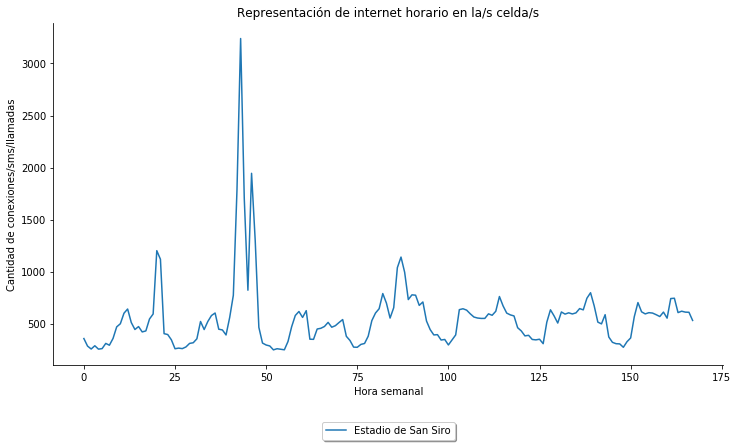

In [25]:
representa_actividad_celda(df_cdrs, 
                           [5737],
                           ['Estadio de San Siro'], 
                           'internet')

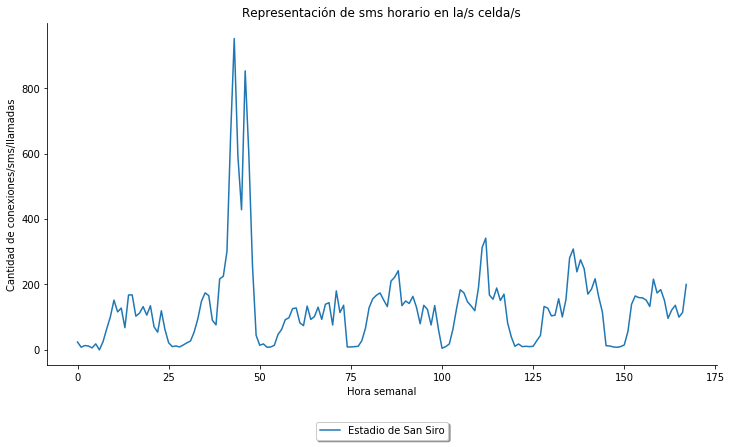

In [26]:
representa_actividad_celda(df_cdrs, 
                           [5737],
                           ['Estadio de San Siro'], 
                           'sms')

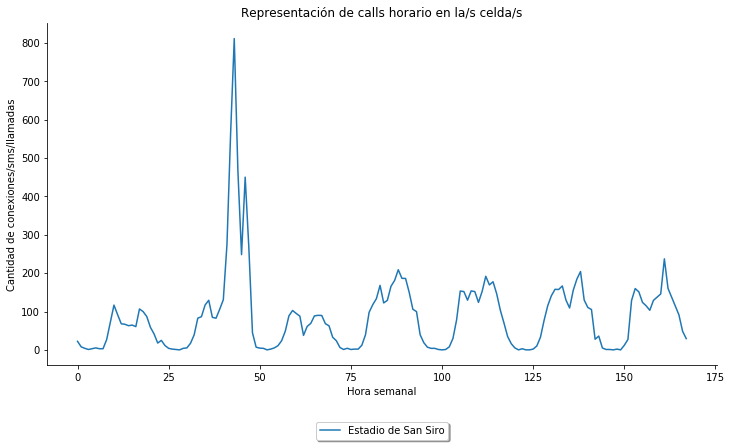

In [27]:
representa_actividad_celda(df_cdrs, 
                           [5737],
                           ['Estadio de San Siro'], 
                           'calls')